In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 2.8 MB/s 
     |████████████████████████████████| 376 kB 39.6 MB/s 
     |████████████████████████████████| 58 kB 3.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=5f478749dd079611878acd8e1fc7421f21869962eac39dde386bfc963ea08cf5
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=e552e7ac1a4cba5158a29f8f7567ed5b0a4ff4bec10628b1a3fd6f179feb3d1f
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 18.89 MiB/s, done.
Checking out files: 100% (12939/12939), done.


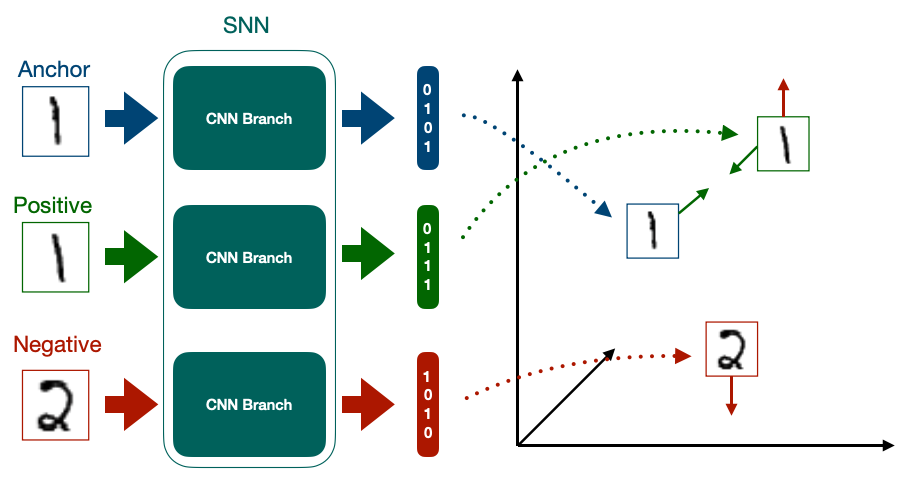

# Imports

In [ ]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[3]
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

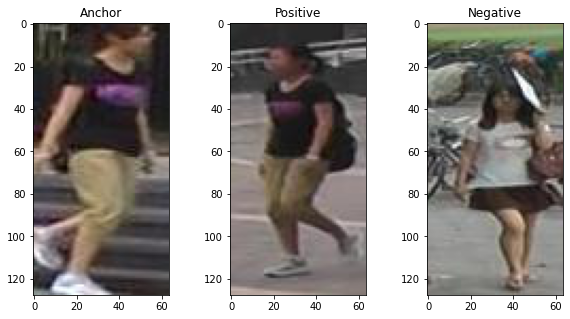

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Create APN Dataset 

In [ ]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img

In [ ]:
trainset =  APN_Dataset(train_df)
validset =  APN_Dataset(valid_df)

print(len(trainset))
print(len(validset))

3200
800


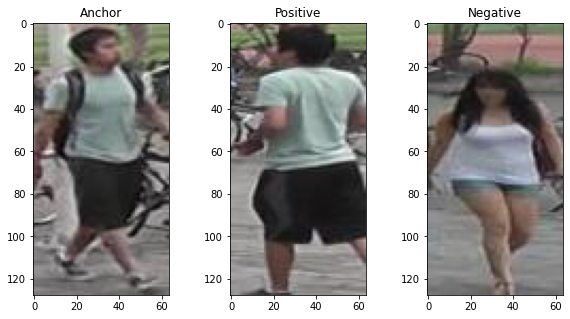

In [ ]:
idx = 50
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A, P, N in trainloader:
  break;
    
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [ ]:
from enum import EnumMeta
from torch.nn.modules.sparse import Embedding
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
      super(APN_Model, self).__init__()

      self.efficientnet = timm.create_model('efficientnet_b0', pretrained= True)
      self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)
  
  def forward(self, images):

    embedding = self.efficientnet(images)
    return embedding

In [ ]:
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine

# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):

    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader, criterion):

  model.eval() # OFF Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):

      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()
      
    return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginWithDistanceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED_WIGHT_SUCCESS")
  
  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss: {valid_loss}")

100%|██████████| 25/25 [00:02<00:00,  8.42it/s]


SAVED_WIGHT_SUCCESS
EPOCHS : 1 train_loss : 0.18461420372128487 valid_loss: 0.26711649298667905


100%|██████████| 25/25 [00:02<00:00,  9.45it/s]


SAVED_WIGHT_SUCCESS
EPOCHS : 2 train_loss : 0.12392008617520332 valid_loss: 0.23043003797531128


100%|██████████| 25/25 [00:02<00:00,  9.50it/s]


SAVED_WIGHT_SUCCESS
EPOCHS : 3 train_loss : 0.0892724372446537 valid_loss: 0.2066474562883377


100%|██████████| 25/25 [00:02<00:00,  9.50it/s]


SAVED_WIGHT_SUCCESS
EPOCHS : 4 train_loss : 0.07012229494750499 valid_loss: 0.12830995440483092


100%|██████████| 25/25 [00:02<00:00,  9.54it/s]


EPOCHS : 5 train_loss : 0.05773550897836685 valid_loss: 0.1787906575202942


100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


EPOCHS : 6 train_loss : 0.05401282049715519 valid_loss: 0.15909784078598022


100%|██████████| 25/25 [00:04<00:00,  6.16it/s]


EPOCHS : 7 train_loss : 0.046231074780225756 valid_loss: 0.13178471028804778


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


EPOCHS : 8 train_loss : 0.048466857075691226 valid_loss: 0.1396071755886078


100%|██████████| 25/25 [00:04<00:00,  6.10it/s]


EPOCHS : 9 train_loss : 0.03625093519687653 valid_loss: 0.16503525912761688


100%|██████████| 25/25 [00:04<00:00,  5.49it/s]


EPOCHS : 10 train_loss : 0.04042713165283203 valid_loss: 0.17265201717615128


100%|██████████| 25/25 [00:04<00:00,  5.17it/s]


EPOCHS : 11 train_loss : 0.036846825331449506 valid_loss: 0.15029083847999572


100%|██████████| 25/25 [00:03<00:00,  6.30it/s]


EPOCHS : 12 train_loss : 0.03163462907075882 valid_loss: 0.20885711371898652


100%|██████████| 25/25 [00:04<00:00,  6.00it/s]


EPOCHS : 13 train_loss : 0.04195786267518997 valid_loss: 0.19859787195920944


100%|██████████| 25/25 [00:04<00:00,  6.03it/s]


EPOCHS : 14 train_loss : 0.04063812121748924 valid_loss: 0.1782931411266327


100%|██████████| 25/25 [00:04<00:00,  5.57it/s]

EPOCHS : 15 train_loss : 0.06595683373510837 valid_loss: 0.20914598435163498


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1)/ 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) # (c, h, w) -> (bs, c, h, w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())
    
    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    
    df_enc = pd.concat([anc_img_names, encodings], axis= 1)

    return df_enc


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:48<00:00, 82.19it/s]


In [ ]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.134298,-0.161555,0.403195,0.254750,0.170031,-0.380472,-0.495085,0.835599,-0.771535,...,-0.929808,-0.180959,-0.374061,-0.590657,-0.393460,0.147896,0.901909,0.763016,0.146919,0.011153
1,1420_c3s3_061978_03.jpg,0.063652,-0.081125,0.033429,0.281781,-0.216454,-0.122238,-0.607843,0.315043,-0.552396,...,-0.395195,-0.560973,-0.161886,-0.436502,0.046589,0.469074,0.835669,-0.005998,-0.333382,0.315087
2,1420_c5s3_062565_05.jpg,-0.265660,-0.161635,0.247118,0.456853,-0.361251,-0.014521,-0.742527,0.530011,-0.977835,...,-0.796557,-0.440001,-0.433082,-0.698117,0.371561,0.428203,0.824947,-0.071884,-0.234030,0.117205
3,1420_c6s3_085592_04.jpg,0.604231,0.134709,0.343742,0.370084,0.467387,-0.480743,-0.592934,0.831026,-0.434042,...,-1.093172,-0.006267,-0.100155,-0.648986,-0.479509,-0.011222,1.217977,0.766579,0.232337,0.001532
4,0663_c5s3_085987_03.jpg,-0.481696,0.221083,-0.220820,-0.370521,-0.485426,1.086542,0.545530,0.299191,0.399392,...,1.402625,0.486494,0.671685,-0.191349,-0.271695,0.340809,-0.426243,0.506302,0.374869,-0.222454


# Inference

In [ ]:
def euclidean_dist(img_enc, enc_arr ):
  dist = np.sqrt(np.dot((img_enc - enc_arr), (img_enc - enc_arr).T))
  return dist

In [ ]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
  distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.7/dist-packages/networkx/drawing/layout.py:727: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


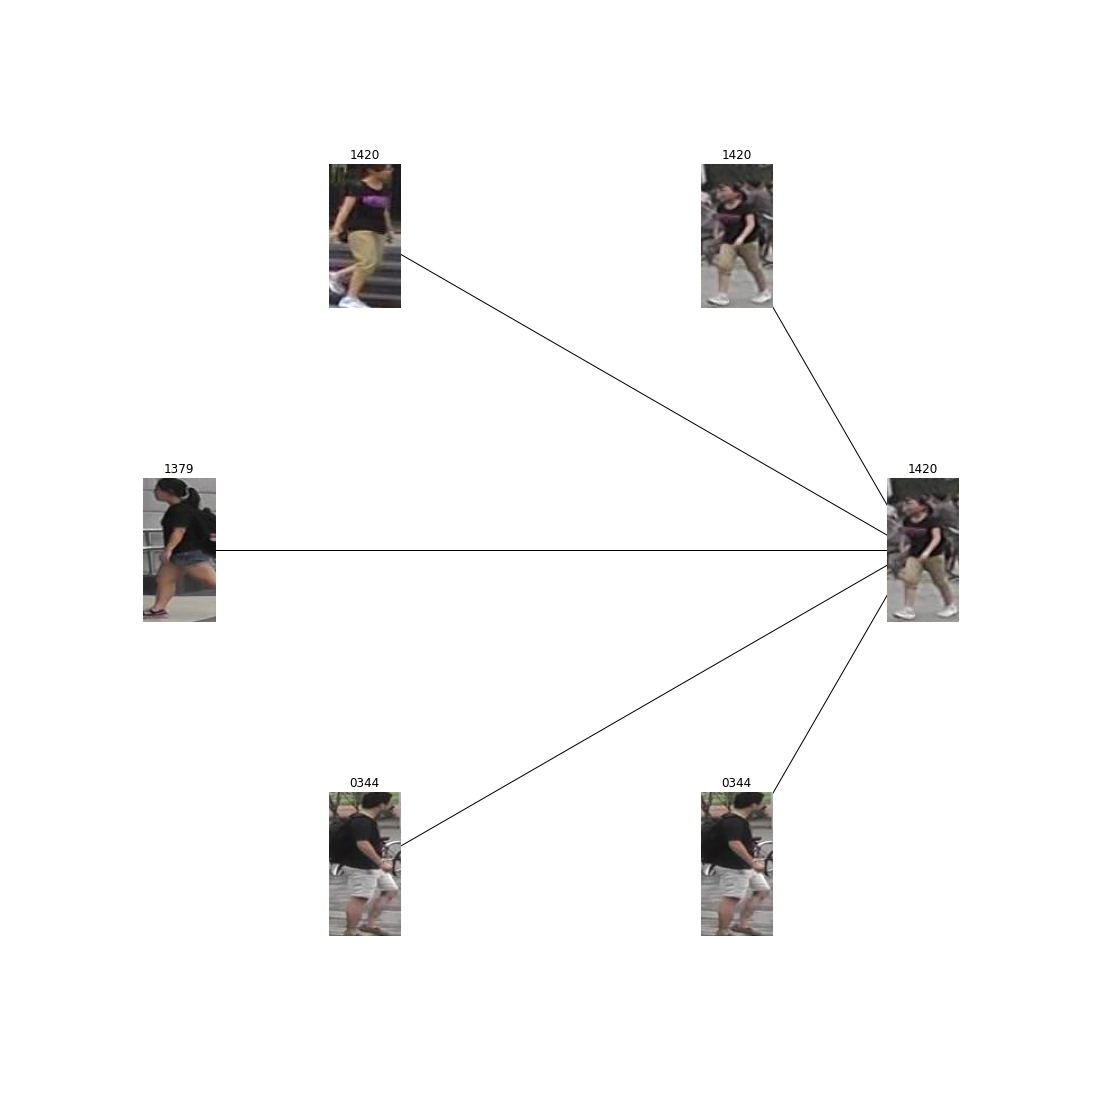

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);